# Improve a Fixed Model the Data-Centric Way!

Data-centric way allows improve predictive ability of model without changing it's architecture. One famous principle of data science says "garbage in - garbage out". The goal of this competition is preprocessing of dataset for molecular oxygen concentration prediction. In this competition model is fixed. Our goal is clean the data for this model. Let's go!

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import TheilSenRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv',
                   dtype='float32'
                  )
data['id'] = data['id'].astype('int32')
display(data.head())
data.info()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000000,9.545,9.265,8.110,8.43,7.15,0.180,...,4.950000,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.900002,8.770,9.265,6.015,10.07,7.15,1.107,...,20.049999,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.420000,8.770,9.265,4.550,10.07,7.15,0.020,...,4.580000,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.100000,9.500,9.200,5.200,8.67,6.67,0.280,...,8.450000,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.650000,7.960,9.265,3.290,10.07,7.15,0.360,...,2.020000,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3500 non-null   int32  
 1   target  3500 non-null   float32
 2   O2_1    3500 non-null   float32
 3   O2_2    3500 non-null   float32
 4   O2_3    3500 non-null   float32
 5   O2_4    3500 non-null   float32
 6   O2_5    3500 non-null   float32
 7   O2_6    3500 non-null   float32
 8   O2_7    3500 non-null   float32
 9   NH4_1   3500 non-null   float32
 10  NH4_2   3500 non-null   float32
 11  NH4_3   3500 non-null   float32
 12  NH4_4   3500 non-null   float32
 13  NH4_5   3500 non-null   float32
 14  NH4_6   3500 non-null   float32
 15  NH4_7   3500 non-null   float32
 16  NO2_1   3500 non-null   float32
 17  NO2_2   3500 non-null   float32
 18  NO2_3   3500 non-null   float32
 19  NO2_4   3500 non-null   float32
 20  NO2_5   3500 non-null   float32
 21  NO2_6   3500 non-null   float32
 22  

We have dataset with 37 columns: id column, 35 features and 1 target. We'll use this dataset to predict dissolved oxygen concentration with using random forest regressor given below.

In [3]:
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)


# EDA

Let's take a look on distributions of target and features.

<Axes: xlabel='target', ylabel='Density'>

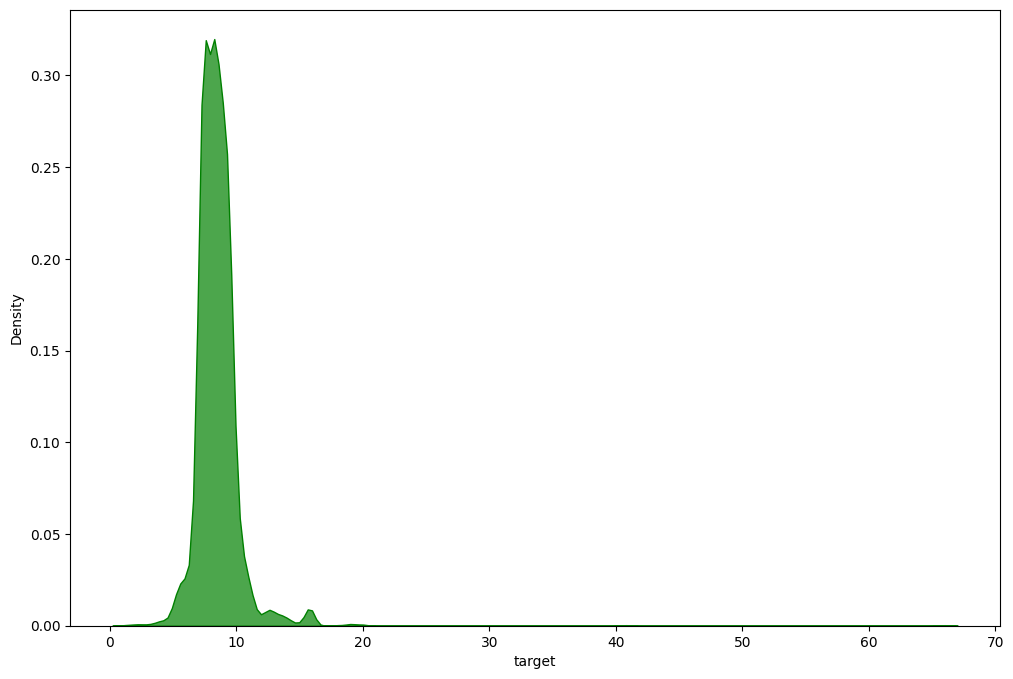

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(ax=ax, data=data, x='target', fill=True, color='green', alpha=0.7)

The distribution of target value is skewed right. However, we use 'woody' model and we can't just drop infrequent values (target > 20), where kernel density is close to 0 because random forest can't extrapolate.
Perhaps there's some feature in this dataset ***have similar distribution and highly correlated with target***.

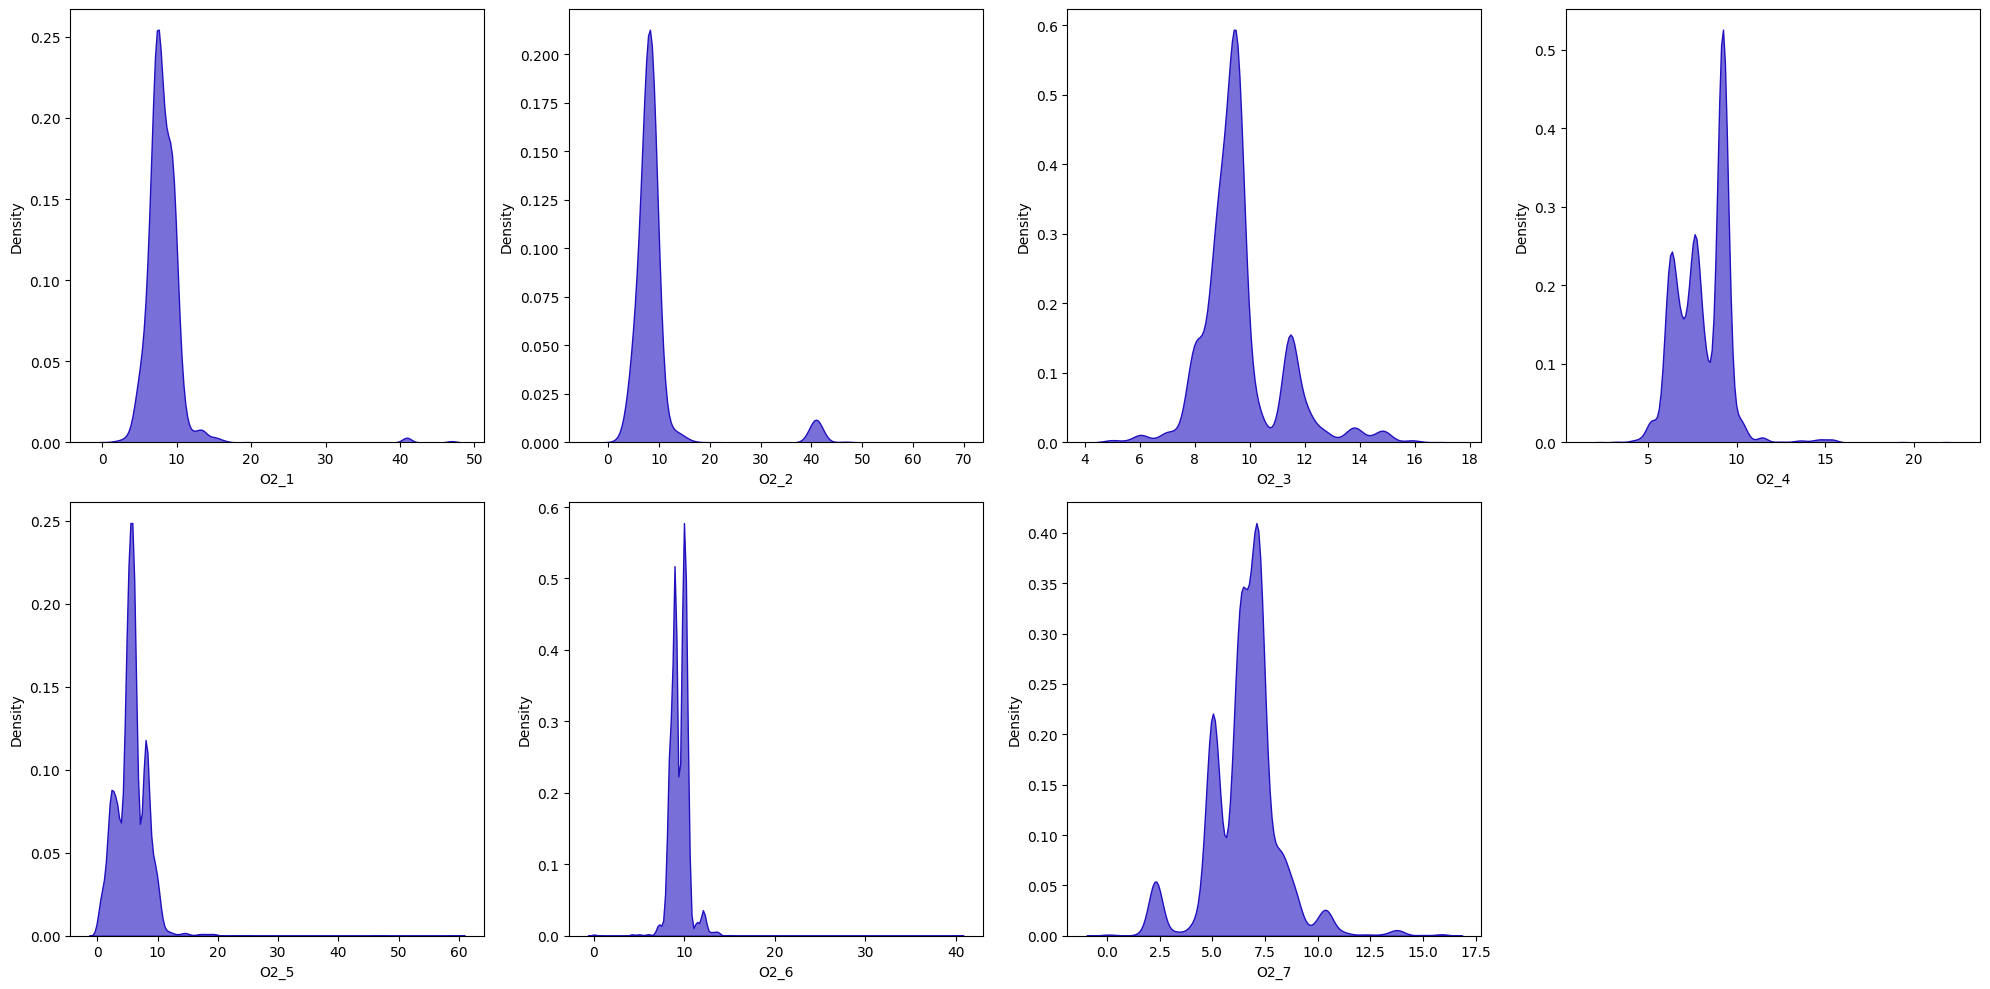

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = []
for i in range(7):
    ax.append(fig.add_subplot(2, 4, i+1))
    sns.kdeplot(ax=ax[-1], data=data, x=f'O2_{i+1}', alpha=0.6, fill=True, color='#2010c0')
fig.tight_layout()

O2_1 feature and target have similar distribution. Let's take a look on correlation plot to check our hypothesis.

<Axes: >

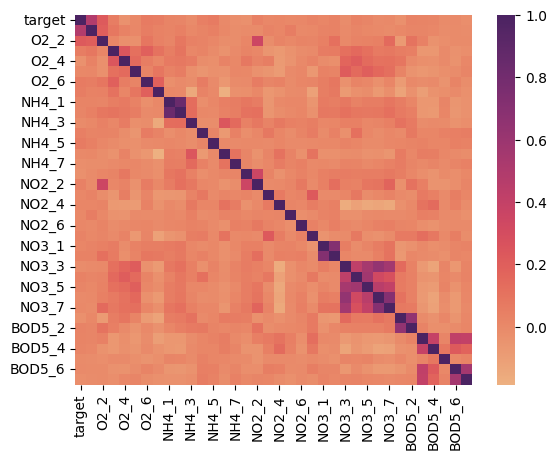

In [6]:
sns.heatmap(data.drop('id', axis=1).corr(), cmap=sns.color_palette('flare', as_cmap=True))

Our hypothesis is confirmed. O2_1 and target are correlated.
Some of features (e.g. O2_2 and NO2_2, NO3_1 and NO3_2 are highly correlated too. We can use auxiliary regression models for outlier reduction, i.e TheilSenRegressor.

In [7]:
def make_regressor(x, y):
    """Trains TheilSenRegressor and visualizes observed dependences"""
    tsr = TheilSenRegressor(n_subsamples=40, 
                        max_iter=1000).fit(data[x].values.reshape(-1, 1),
                                           data[y]
                                          )
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(data[x], data[y], 'ro')
    ax.plot(data[x], tsr.predict(data[x].values.reshape(-1, 1)), 'b-')
    ax.set_xlabel(x, fontsize=14)
    ax.set_ylabel(y, fontsize=14)
    ax.tick_params(labelsize=12)
    return tsr

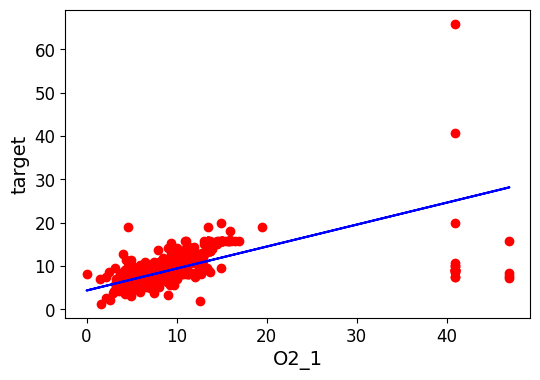

In [8]:
tsr_o21_target = make_regressor('O2_1', 'target')

Some points look like outliers. We want to save most of data so we can correct target value for these ones, i.e. with mixing regressor predictions and original values in some ratio.

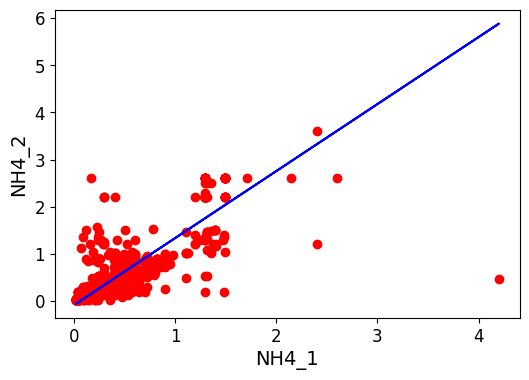

In [9]:
tsr_nh41_nh42 = make_regressor('NH4_1', 'NH4_2')

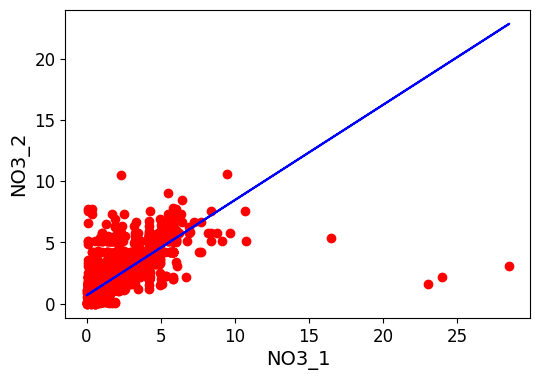

In [10]:
tsr_no31_no32 = make_regressor('NO3_1', 'NO3_2')

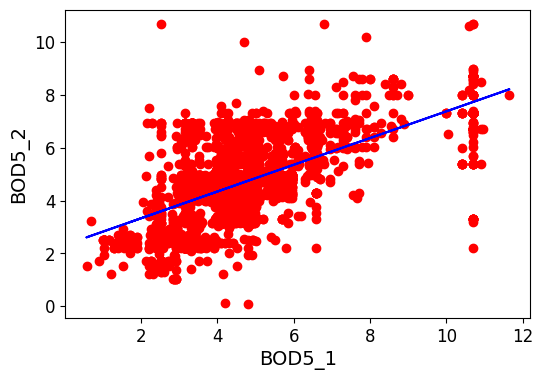

In [11]:
tsr_bod51_bod52 = make_regressor('BOD5_1', 'BOD5_2')

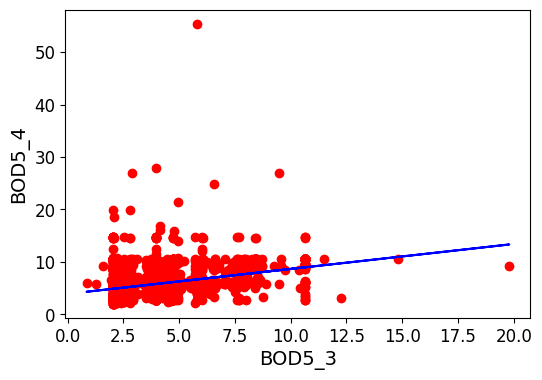

In [12]:
tsr_bod53_bod54 = make_regressor('BOD5_3', 'BOD5_4')

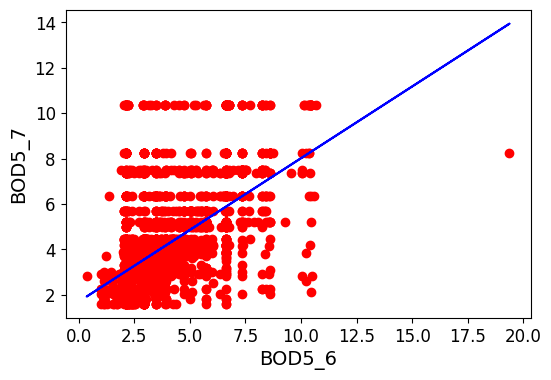

In [13]:
tsr_bod56_bod57 = make_regressor('BOD5_6', 'BOD5_7')

Let's do magic!

## Baseline

Let's split our data into two subsamples in ratio 3:1 to fit RF regressor and calculate RMSE on raw data.

In [14]:
def split_data(df):
    """Splits the dataset into train and valid subsamples"""
    y = df['target']
    X = df.drop(['id', 'target'], axis=1)
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=777)
    return X_train, X_val, y_train, y_val

In [15]:
def eval_data(X_train, y_train, X_val, y_val, rf):
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    val_pred = rf.predict(X_val)
    fig, ax = plt.subplots(figsize=(20, 5), ncols=2)
    sns.kdeplot(ax=ax[0], x=y_train-train_pred, fill=True, color='red', alpha=0.7)
    sns.kdeplot(ax=ax[1], x=y_val-val_pred, fill=True, color='blue', alpha=0.7)
    print('RMSE on train data: {}'.format(
        mean_squared_error(train_pred, y_train, squared=False)
    ))
    print('RMSE on validation data: {}'.format(
        mean_squared_error(val_pred, y_val, squared=False)
    ))

In [16]:
X_train, X_val, y_train, y_val = split_data(data)
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

RMSE on train data: 0.9466569394120923
RMSE on validation data: 1.483004218646253


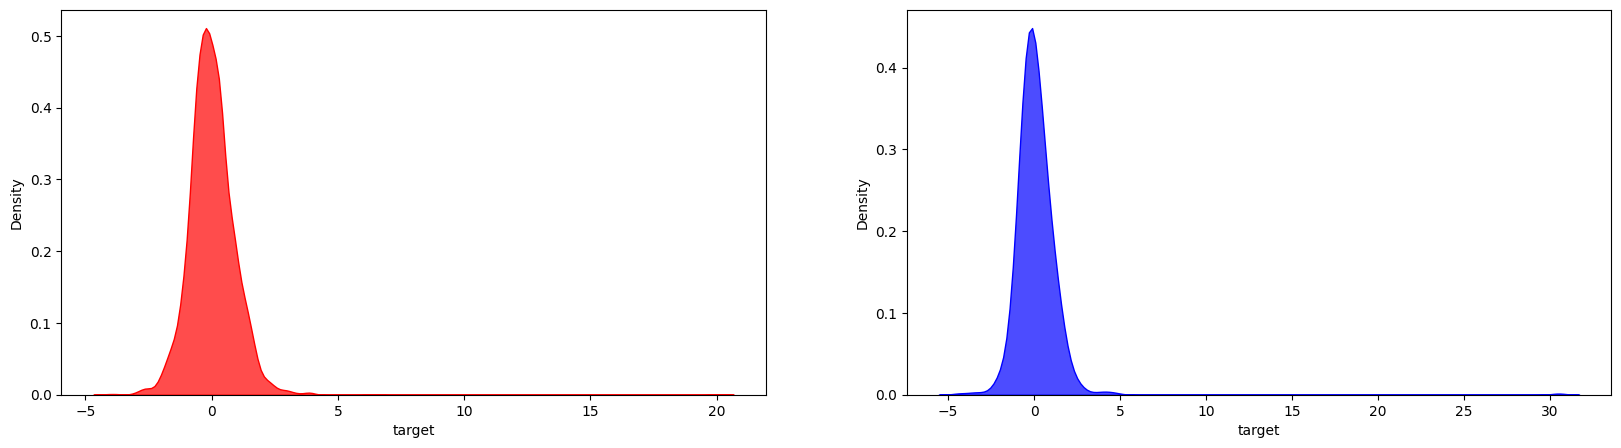

In [17]:
eval_data(X_train, y_train, X_val, y_val, rf)

RMSE on train and validation data is different. However, variances of regression residuals on train and test data are similar but there're long tails both on train and test data regression residuals distribution. Let's try to correct outlier values.

Let's write the function *correct_values*, which calculates weighted sum of original values and TheilSenRegressor predictions. Weights for each point are calculated individually using this formula:

$$
w = \frac{(y_{obs} - y_{pred})^2}{(y_{obs} - y_{pred})^2_{max}}\times \alpha,
$$
where $y_{obs}$ - original value; <br>
      $y_{pred}$ - predicted value; <br>
      $\alpha$ - smoothing factor (hyperparameter).
      
Our data contains outliers, so it's reasonable to use 97 percentile instead of maximal difference and clip the weights for outliers.

In [18]:
def correct_values(df, col, x, tsr, alpha):
    pred = tsr.predict(df[x].values.reshape(-1, 1)) # y_pred
    diff = np.quantile((df['target'] - pred) ** 2, 0.97) # 97 percentile
    coefs = ((df['target'] - pred) ** 2) * alpha / diff # vector of weights
    coefs = np.where(coefs > 1, 1, coefs) # weight clipping
    values = coefs * pred + df[col] * (1 - coefs) # new values calculation
    return values

In [19]:
def correct_data(df, alpha):
    df = df.copy()
    df['target'] =  correct_values(df, 'target', 'O2_1', tsr_o21_target, alpha)
    df['NH4_2'] = correct_values(df, 'NH4_2', 'NH4_1', tsr_nh41_nh42, alpha)
    df['NO3_2'] = correct_values(df, 'NO3_2', 'NO3_1', tsr_no31_no32, alpha)
    df['BOD5_2'] = correct_values(df, 'BOD5_2', 'BOD5_1', tsr_bod51_bod52, alpha)
    df['BOD5_4'] = correct_values(df, 'BOD5_4', 'BOD5_3', tsr_bod53_bod54, alpha)
    df['BOD5_7'] = correct_values(df, 'BOD5_7', 'BOD5_6', tsr_bod56_bod57, alpha)
    X_train, X_val, y_train, y_val = split_data(df)
    eval_data(X_train, y_train, X_val, y_val, rf)
    return df

RMSE on train data: 0.6258992312818934
RMSE on validation data: 0.6883232008569041


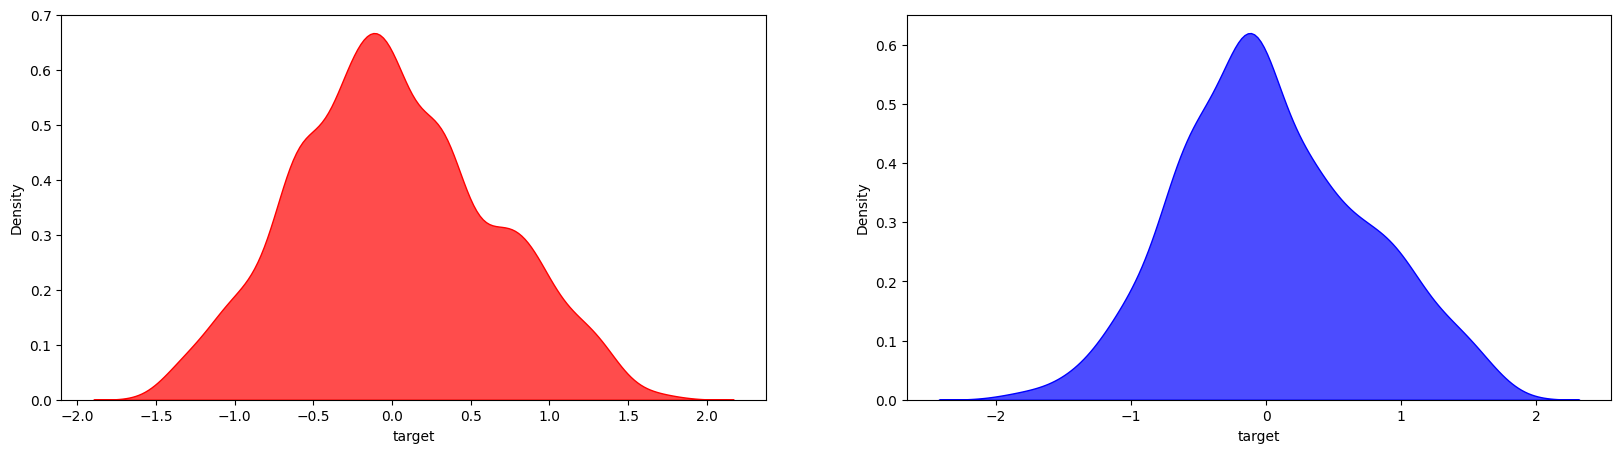

In [20]:
new_df = correct_data(data, 0.5)

Distribution of regression residuals became similar. Let's make a submission!

In [21]:
new_df.to_csv('submission.csv', index=False)